<a href="https://colab.research.google.com/github/grzegorzkwolek/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/GKwolek_assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [X] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [X] Engineer at least two new features. (See below for explanation & ideas.)
- [X] Fit a linear regression model with at least two features.
- [X] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df.shape

(48817, 34)

In [0]:
df.dtypes
#do we have date? Nope. We have something looking like date

bathrooms               float64
bedrooms                  int64
created                  object
description              object
display_address          object
latitude                float64
longitude               float64
price                     int64
street_address           object
interest_level           object
elevator                  int64
cats_allowed              int64
hardwood_floors           int64
dogs_allowed              int64
doorman                   int64
dishwasher                int64
no_fee                    int64
laundry_in_building       int64
fitness_center            int64
pre-war                   int64
laundry_in_unit           int64
roof_deck                 int64
outdoor_space             int64
dining_room               int64
high_speed_internet       int64
balcony                   int64
swimming_pool             int64
new_construction          int64
terrace                   int64
exclusive                 int64
loft                      int64
garden_p

In [0]:
df['interest_level'] = pd.Categorical(df['interest_level'])

In [0]:
df['interest_level_code'] = df['interest_level'].cat.codes
#will check if this makes sense for the model (new feature)

In [0]:
df['interest_level'].unique()

[medium, low, high]
Categories (3, object): [medium, low, high]

In [0]:
df['total_rooms'] = df['bathrooms'] + df ['bedrooms']

In [0]:
df['created'] = pd.to_datetime(df['created'], infer_datetime_format = 'true')

In [0]:
start_date = pd.datetime(2016, 4, 1)
end_date = pd.datetime(2016, 5, 31)

mask_train = (df['created'] <= end_date)
mask_test = (df['created'] > end_date)

In [0]:
# creating the sets, as required
train_df = df[mask_train]
test_df = df[mask_test]

In [0]:
train_df.shape[0] + test_df.shape[0]

48817

In [0]:
train_df.sample(10)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,interest_level_code,total_rooms
43489,1.0,2,2016-04-28 16:34:36,This is a TRUE 2br centrally located in the Ea...,East 11th Street and 2nd avenue,40.7304,-73.9860,3400,299 East 11th Street,high,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
2552,2.0,5,2016-04-07 02:28:54,This apartment in the heart of the Upper West ...,West 108th Street,40.7994,-73.9598,6000,4 West 108th Street,low,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.0
39452,1.0,1,2016-05-25 04:38:00,+ MASSIVE 1 Bedroom Corner Suite<br /><br />+ ...,E 86 Street,40.7771,-73.9505,3100,336 E 86 Street,low,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0
36270,1.0,1,2016-05-10 03:38:46,This great 1 bedroom apartment is conveniently...,34-09 83rd St.,40.7536,-73.8836,1900,34-09 83rd St.,low,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2.0
28785,1.0,2,2016-05-08 05:24:43,Large Private Patio Ebony Hardwood Floors Gou...,Keap St,40.7087,-73.9550,3415,331 Keap St,low,0,1,1,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,3.0
1529,1.0,0,2016-04-05 03:59:19,Great price for this studio located on 74th st...,E 74 Street,40.7690,-73.9541,1850,409 E 74 Street,low,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.0
6021,1.0,1,2016-04-06 05:31:40,STUNNING VIEWS FROM THE 44TH FLOOR!! HUGE 1 BE...,W 67 Street,40.7756,-73.9833,3475,145 W 67 Street,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0
35732,1.0,0,2016-05-06 02:42:37,Nice Studio apartment on sunny tree-lined bloc...,90th & 2nd HUGE,40.7798,-73.9491,1825,302 E 90 Street,high,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
47011,1.0,1,2016-04-29 04:13:06,REMODELED ONE BEDROOM WITH LOFT IN ELEVATOR BU...,W 75 St.,40.7824,-73.9840,2725,323 W 75 St.,low,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2.0
7564,1.0,2,2016-04-02 05:56:53,THIS TRIBECA SOUTH UNIT FEATURES : Gourmet sty...,Spruce Street,40.7111,-74.0055,2700,8 Spruce Street,low,1,0,1,0,1,1,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,3.0


In [0]:
from sklearn.metrics import mean_absolute_error

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [0]:
features = ['total_rooms',
            'interest_level_code']
X_train = train_df[features]
X_test = test_df[features]

target = 'price'
y_train = train_df[target]
y_test = test_df[target]

In [0]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

train_mae = mean_absolute_error(y_train, y_pred)
mean_rental = df['price'].mean()

print(f'Linear Regression, dependent on: {features}')
print(f'Train Error: {train_mae:.2f} vs the mean rental price of {mean_rental:.2f}')

Linear Regression, dependent on: ['total_rooms', 'interest_level_code']
Train Error: 891.67 vs the mean rental price of 3579.59


In [0]:
y_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
mean_rental = df['price'].mean()
print(f'Linear Regression, dependent on: {features}')
print(f'Test Error: {test_mae:.2f} vs the mean rental price of {mean_rental:.2f}')

Linear Regression, dependent on: ['total_rooms', 'interest_level_code']
Test Error: 908.24 vs the mean rental price of 3579.59


In [0]:
model.intercept_, model.coef_

(1529.541096812685, array([ 810.93685422, -146.43777921]))

In [0]:
#probably a better idea to do stsandaridze the data
from sklearn.preprocessing import StandardScaler

In [0]:
features = ['total_rooms', 
            'interest_level_code']
print(f'Linear Regression, dependent on: {features}')
X_train = train_df[features]
X_test = test_df[features]

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train error: {mae_train:.2f} percentage points')

# Apply the model to new data
y_pred_test = model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test error: {mae_test:.2f} percentage points')

Linear Regression, dependent on: ['total_rooms', 'interest_level_code']
Train error: 891.67 percentage points
Test error: 906.64 percentage points


In [0]:
y_pred_train

array([3151.41480525, 3004.97702604, 5437.7875887 , ..., 3004.97702604,
       2194.04017182, 3815.91388026])

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
y = train_df["price"]

In [0]:
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R^2:', r2)

Mean Squared Error: 1791893.3118898387
Root Mean Squared Error: 1338.616192898412
Mean Absolute Error: 891.6663910792802
R^2: 0.4229691305089486


In [0]:
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('R^2:', r2)

Mean Squared Error: 1789688.9997584433
Root Mean Squared Error: 1337.7925847299512
Mean Absolute Error: 906.6408855074243
R^2: 0.42405367104725844


In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    

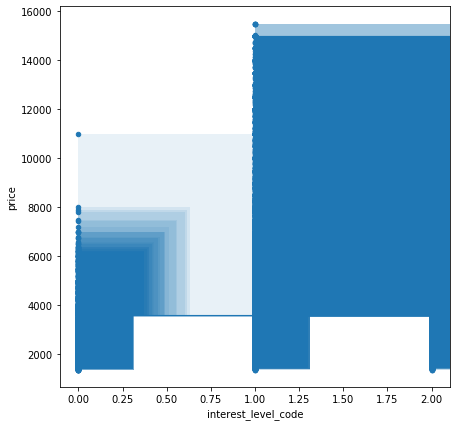

In [0]:
feature = 'interest_level_code'
squared_errors(train_df, feature, target, m=0, b=y_train.mean())

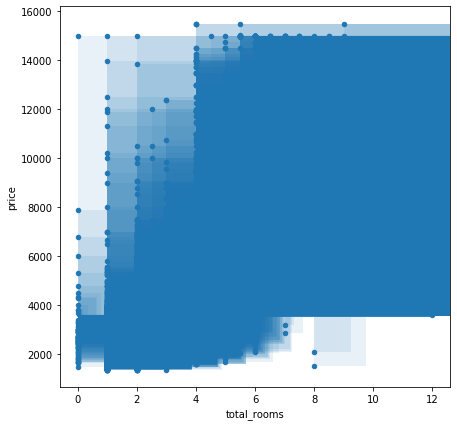

In [0]:
feature = 'total_rooms'
squared_errors(train_df, feature, target, m=0, b=y_train.mean())
#that looks awful!

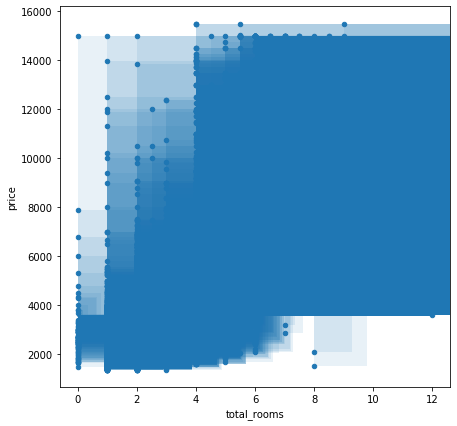

In [0]:
feature = 'total_rooms'
squared_errors(train_df, feature, target, m=3, b=y_train.mean())
#that looks awful! And wrong.